In [1]:
%config Completer.use_jedi = False  # To avoid delays in autocompletion during coding.
import os
import sys
os.chdir('..')  # changing to a higher dir to access custom modules
cwd = os.getcwd()
sys.path.append(cwd)

import numpy as np  # numpy for matrix, linear-algebra, and other numerical studies.
import warnings  # to send warnings to user.
import pandas as pd  # pandas for handling data similar to spreadsheet.
import matplotlib as mpl  # matplotlib for plots
import matplotlib.pyplot as plt  # for plots
import seaborn as sb  # for styling of plots
from PyImModules.matplotlib_settings import *
from itertools import product
from scipy.ndimage import gaussian_filter1d

## Uniqueness of angular coordinate
Consider a straight fibre of length $l_f$ and diameter $d_f$. Let $\phi$ and $\theta$ represent the fibre orientation in spherical coordinates. Then the projected lengths of a fibre along the X, Y, and Z axes are given by:

$$ l_x = l_f \cos\phi \sin\theta; \quad l_y = l_f \sin\phi \sin\theta; \quad l_z = l_f \cos\theta \tag{1}$$

Consider the projection of an SFRC sample along the Z direction. The orientation of fibres measured in this image will directly yield $\phi$ (in XY plane). However, for projections along X and Y axes, the orientation measured is limited to YZ aand XZ planes, respectively. Let the orientation measured on any of these images be $\alpha$. Considering the projection along Y for convenience,

$$ \tan{\alpha} = \dfrac{l_x}{l_z} = \tan{\theta} \cos{\phi} \tag{2}$$

As discussed, for a fibre, $\phi$ and $\alpha$ can be measured from projected images. Then, $\theta$ can be determined from (2), given the equation provides an one-to-one mapping. This is tested in the following code snippet. 

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


shape of alpha:  (180,)
shape of phi:  (180,)
shape of theta:  (180, 180)


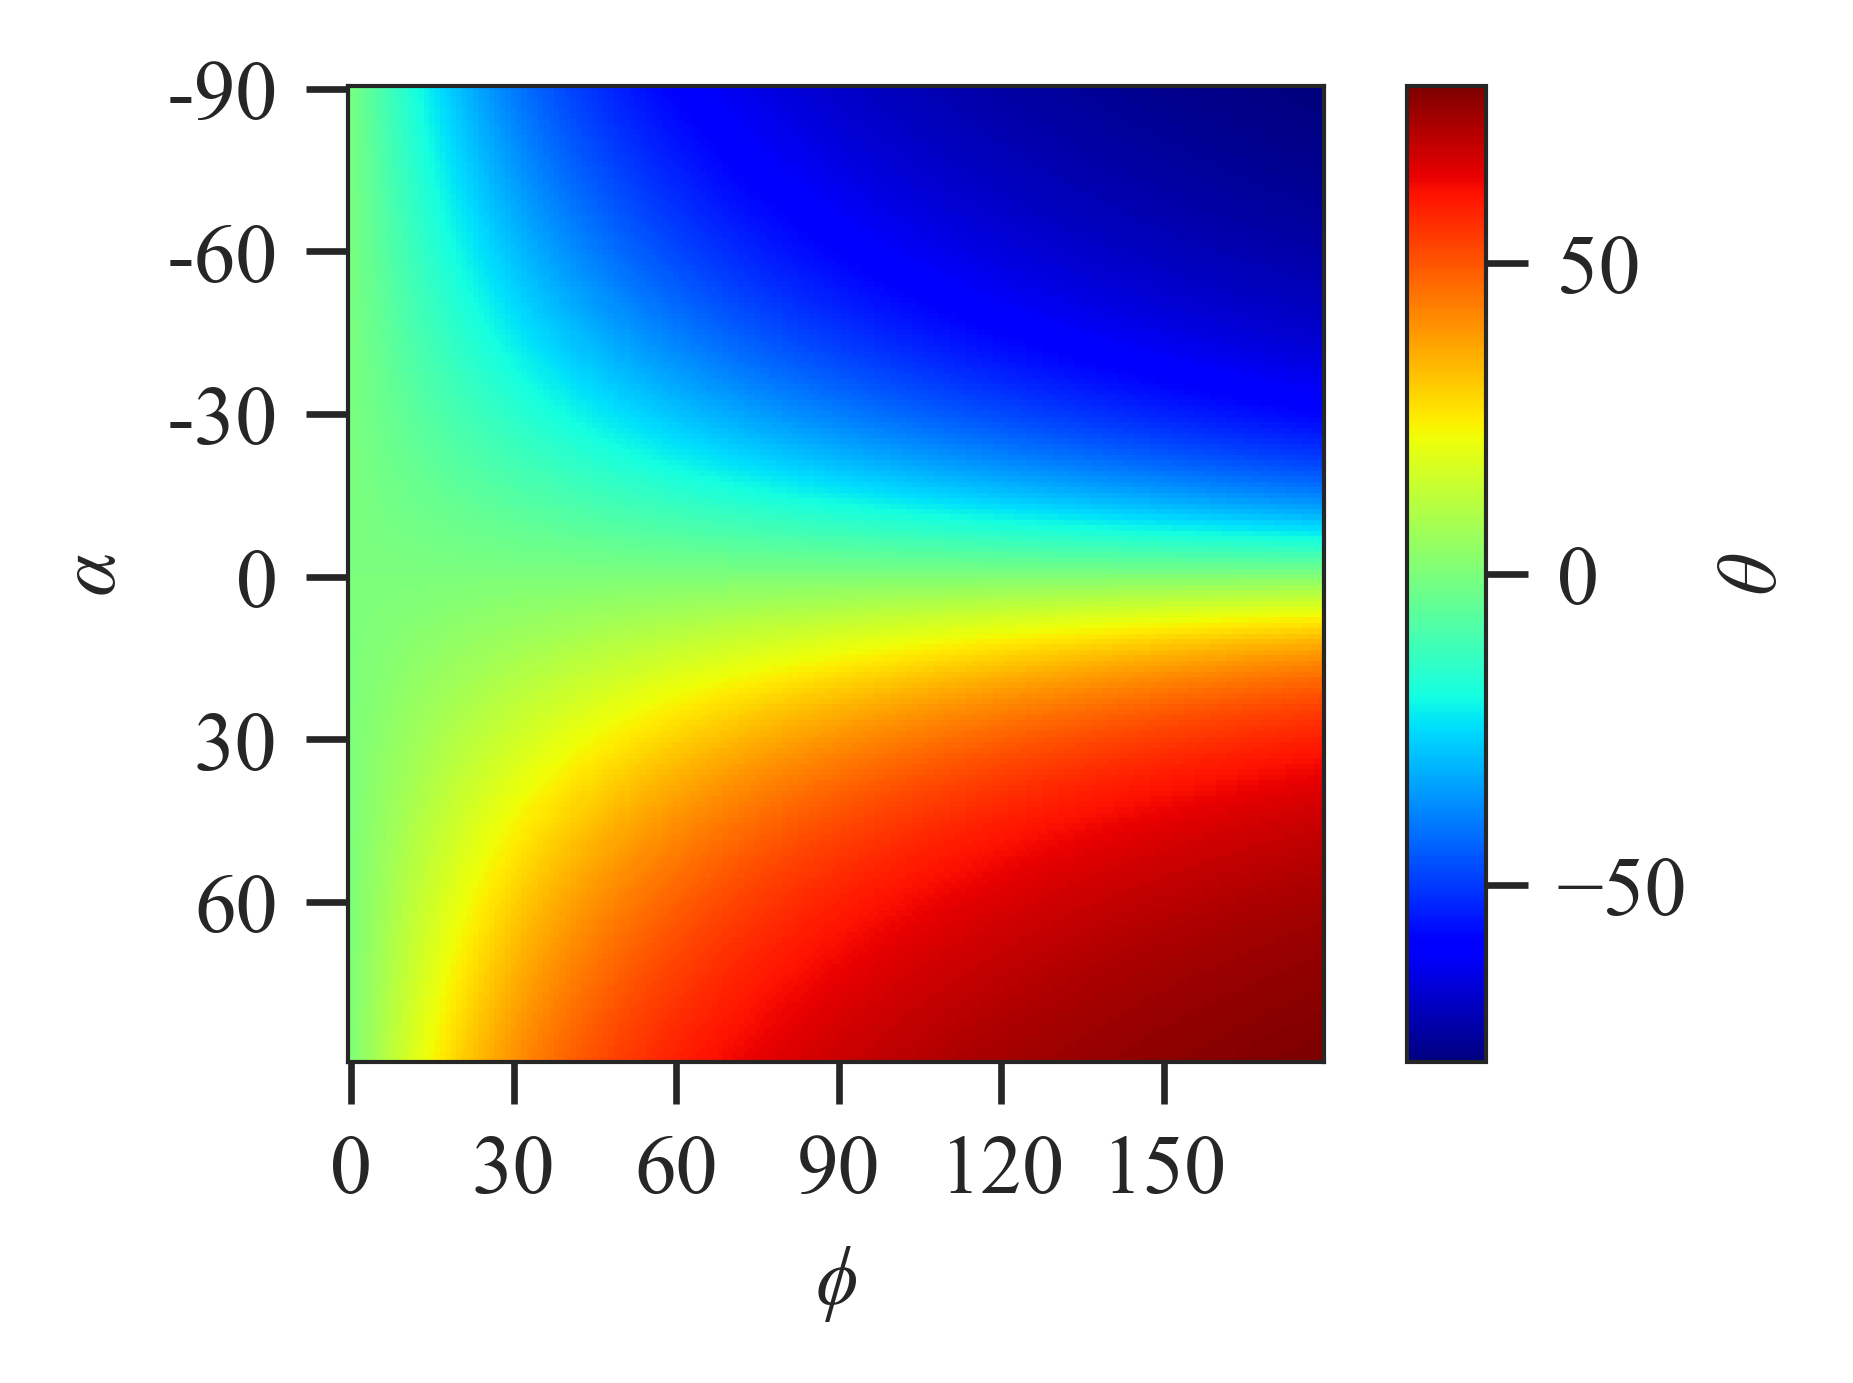

In [2]:
# Verifying the uniqueness of mapping theta from phi, alpha eq 2.
alpha =np.arange(-89.5, 90)  # principal domain of tan is (-90, 90)
phi = np.arange(0.5, 180)  # principal domain of cos is [0, 180)
theta = np.outer(np.deg2rad(alpha),  np.deg2rad(phi))
theta = np.rad2deg(np.arctan(theta))
print("shape of alpha: ", alpha.shape)
print("shape of phi: ", phi.shape)
print("shape of theta: ", theta.shape)

im = plt.imshow(theta, cmap='jet')
ticks = np.arange(len(alpha))
yticks = np.arange(-90, 90)
xticks = np.arange(0, 180)
plt.xticks(ticks[::30], xticks[::30])
plt.yticks(ticks[::30], yticks[::30])
plt.xlabel("$\phi$")
plt.ylabel("$\\alpha$")
cax = plt.colorbar(im)
cax.set_label("$\\theta$")

Total probability of phi:  1.0
Total probability of theta:  0.9999619230641711


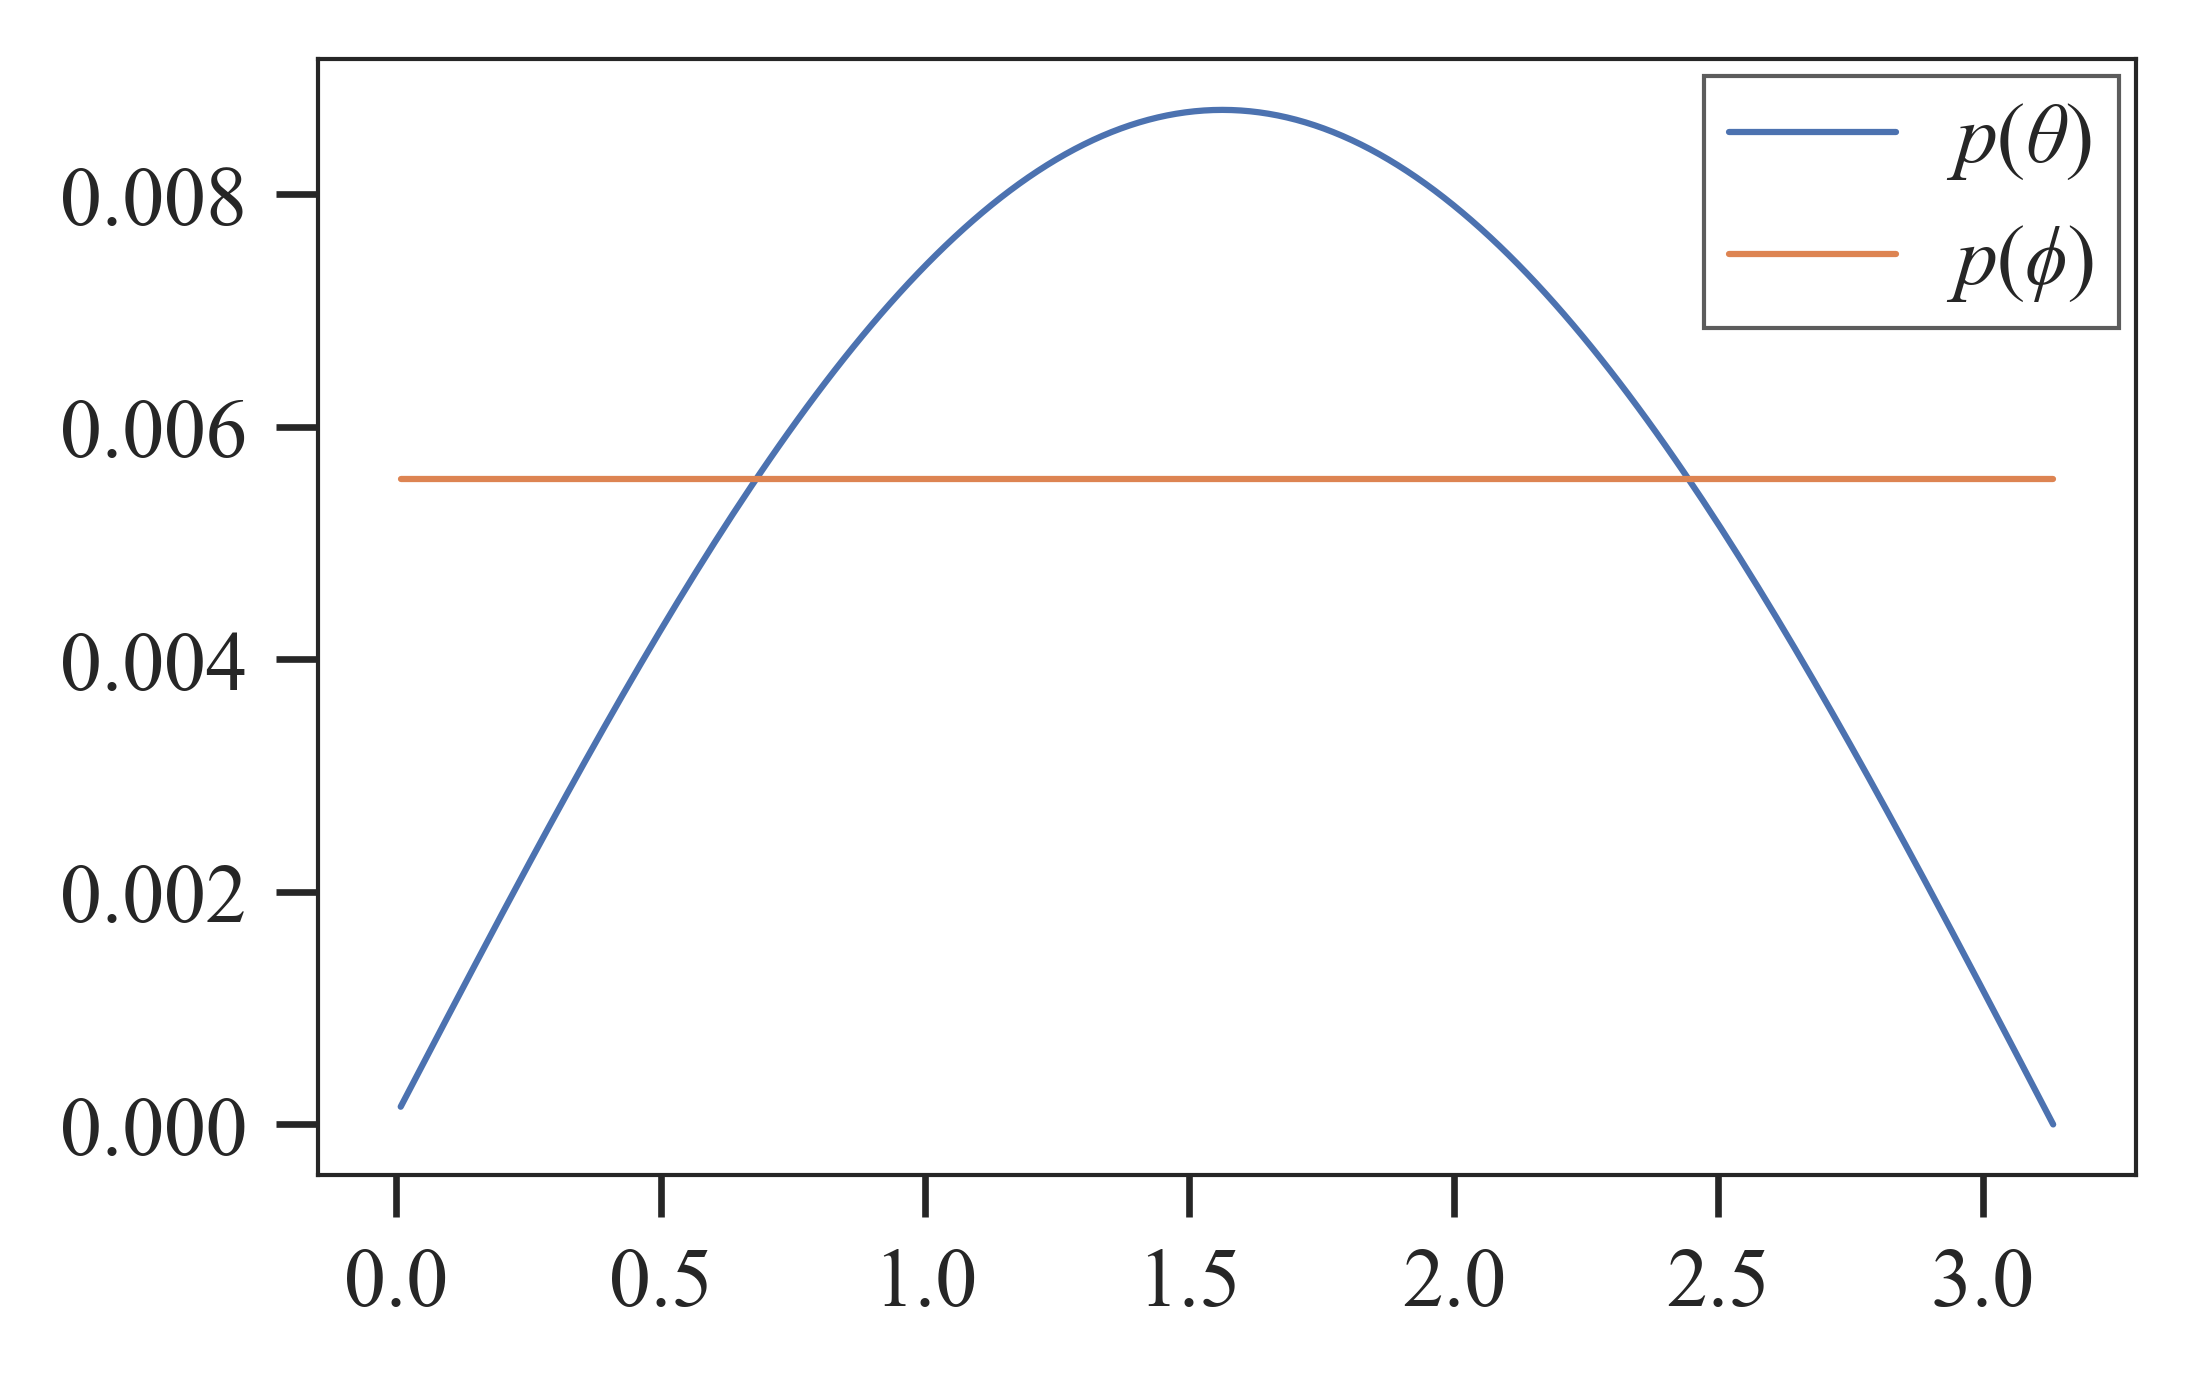

In [3]:
phiDeg = np.arange(0.5, 180)
phi = np.deg2rad(phiDeg)
thetaDeg = phiDeg
theta = phi

dphi = np.pi / len(phi)
dtheta = np.pi / len(theta)
p_phi = np.array([dphi/np.pi]*len(phi))
p_theta = (1 - np.cos(dtheta)) * np.cos(theta) + np.sin(dtheta) * np.sin(theta)
p_theta = 0.5 * p_theta

print("Total probability of phi: ", np.sum(p_phi))
print("Total probability of theta: ", np.sum(p_theta))

fig = plt.figure()
ax = fig.gca()
ax.plot(theta, p_theta, lw=0.75, label='$p(\\theta)$')
ax.plot(phi, p_phi, lw=0.75, label='$p(\phi)$')
ax.legend()

min(alpha): -1.5620693482551937,	 max(alpha): 1.5620693482551937
Checking total proability:  0.9499569017591303
Checking total proability:  0.9499569017591302


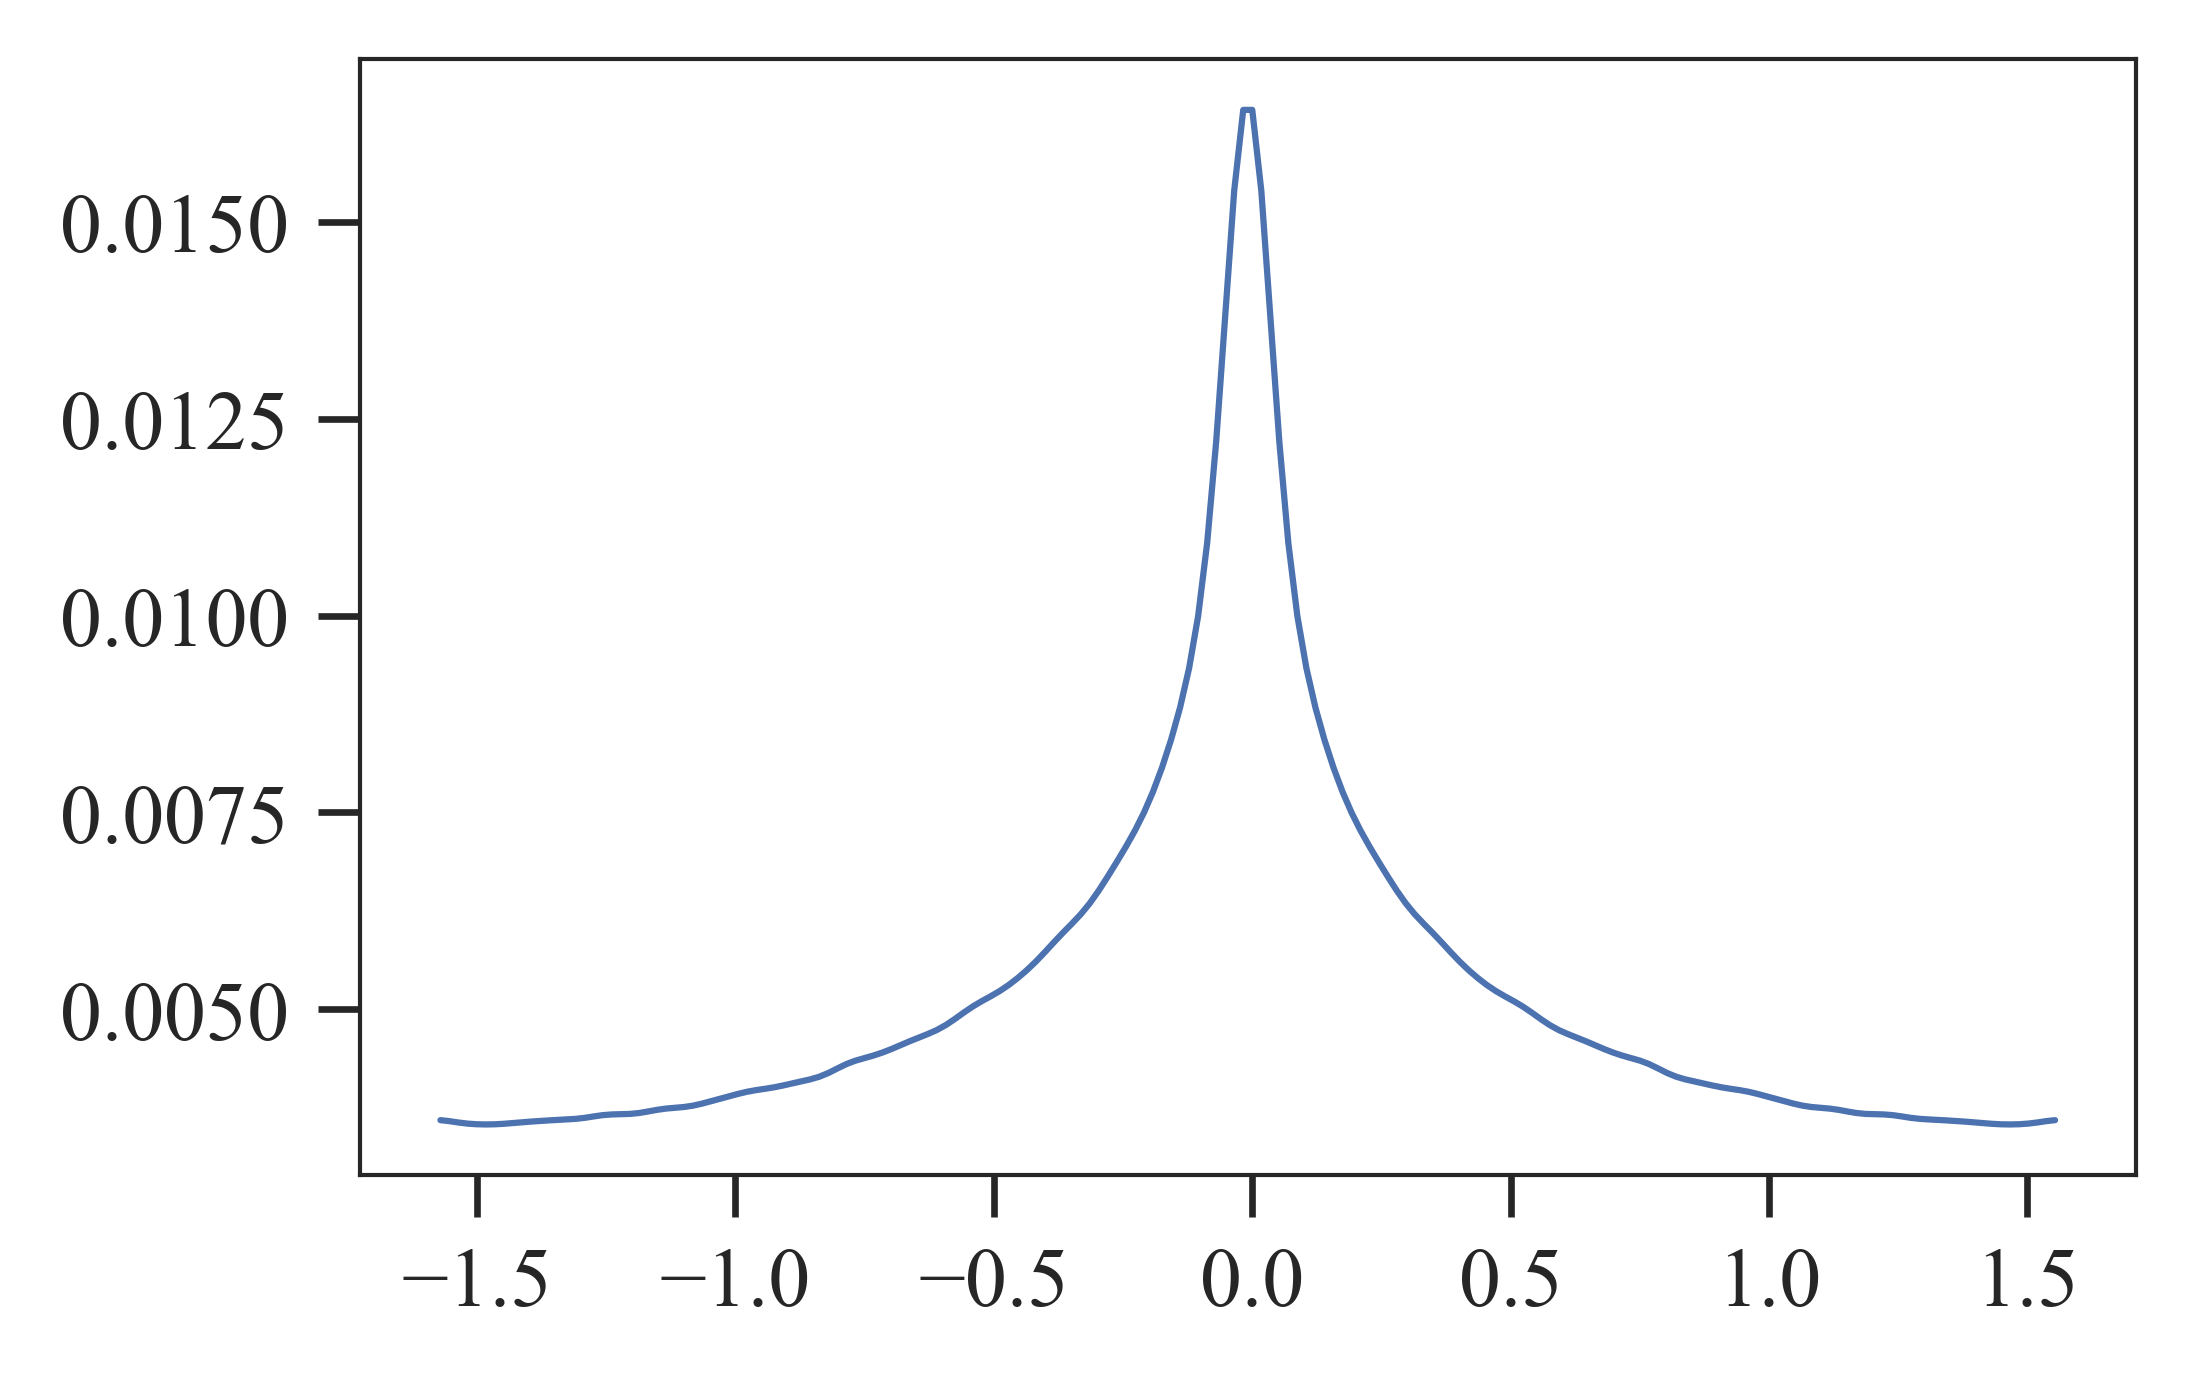

In [4]:
alpha_mat = np.array([np.arctan(np.tan(th) * np.cos(ph)) for th, ph in product(theta, phi)])
alpha_mat = alpha_mat.reshape((len(theta), len(phi)))
print("min(alpha): {0},\t max(alpha): {1}".format(alpha_mat.min(), alpha_mat.max()))

p_joint = np.array([p1 * p2 for p1, p2 in product(p_theta, p_phi)])
p_joint = p_joint.reshape((len(p_theta), len(p_phi)))

alphaDeg = np.arange(-90, 90)
alpha = np.deg2rad(alphaDeg)
dalpha = np.mean(alpha[1:] - alpha[:-1])
p_alpha = []

# refer https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables
for a in alpha:
    p = 0
    for thidx, th in enumerate(theta):
        row = alpha_mat[thidx, :]
        mask = (a < row) & (row <= a + dalpha)
        p += np.sum(p_joint[thidx, :] * mask) / np.abs(th)
    p_alpha.append(p)
print("Checking total proability: ", np.sum(p_alpha))
p_alpha = gaussian_filter1d(p_alpha, 2)
print("Checking total proability: ", np.sum(p_alpha))

fig = plt.figure()
ax = fig.gca()
ax.plot(alpha, p_alpha, lw=0.75, label='$p(\\alpha)$')

min(theta): -1.5707201714734782,	 max(theta): 1.5707201714734782
Checking total proability:  1.0
Checking total proability:  1.4921888118967024
Checking total proability:  1.4921888118967024


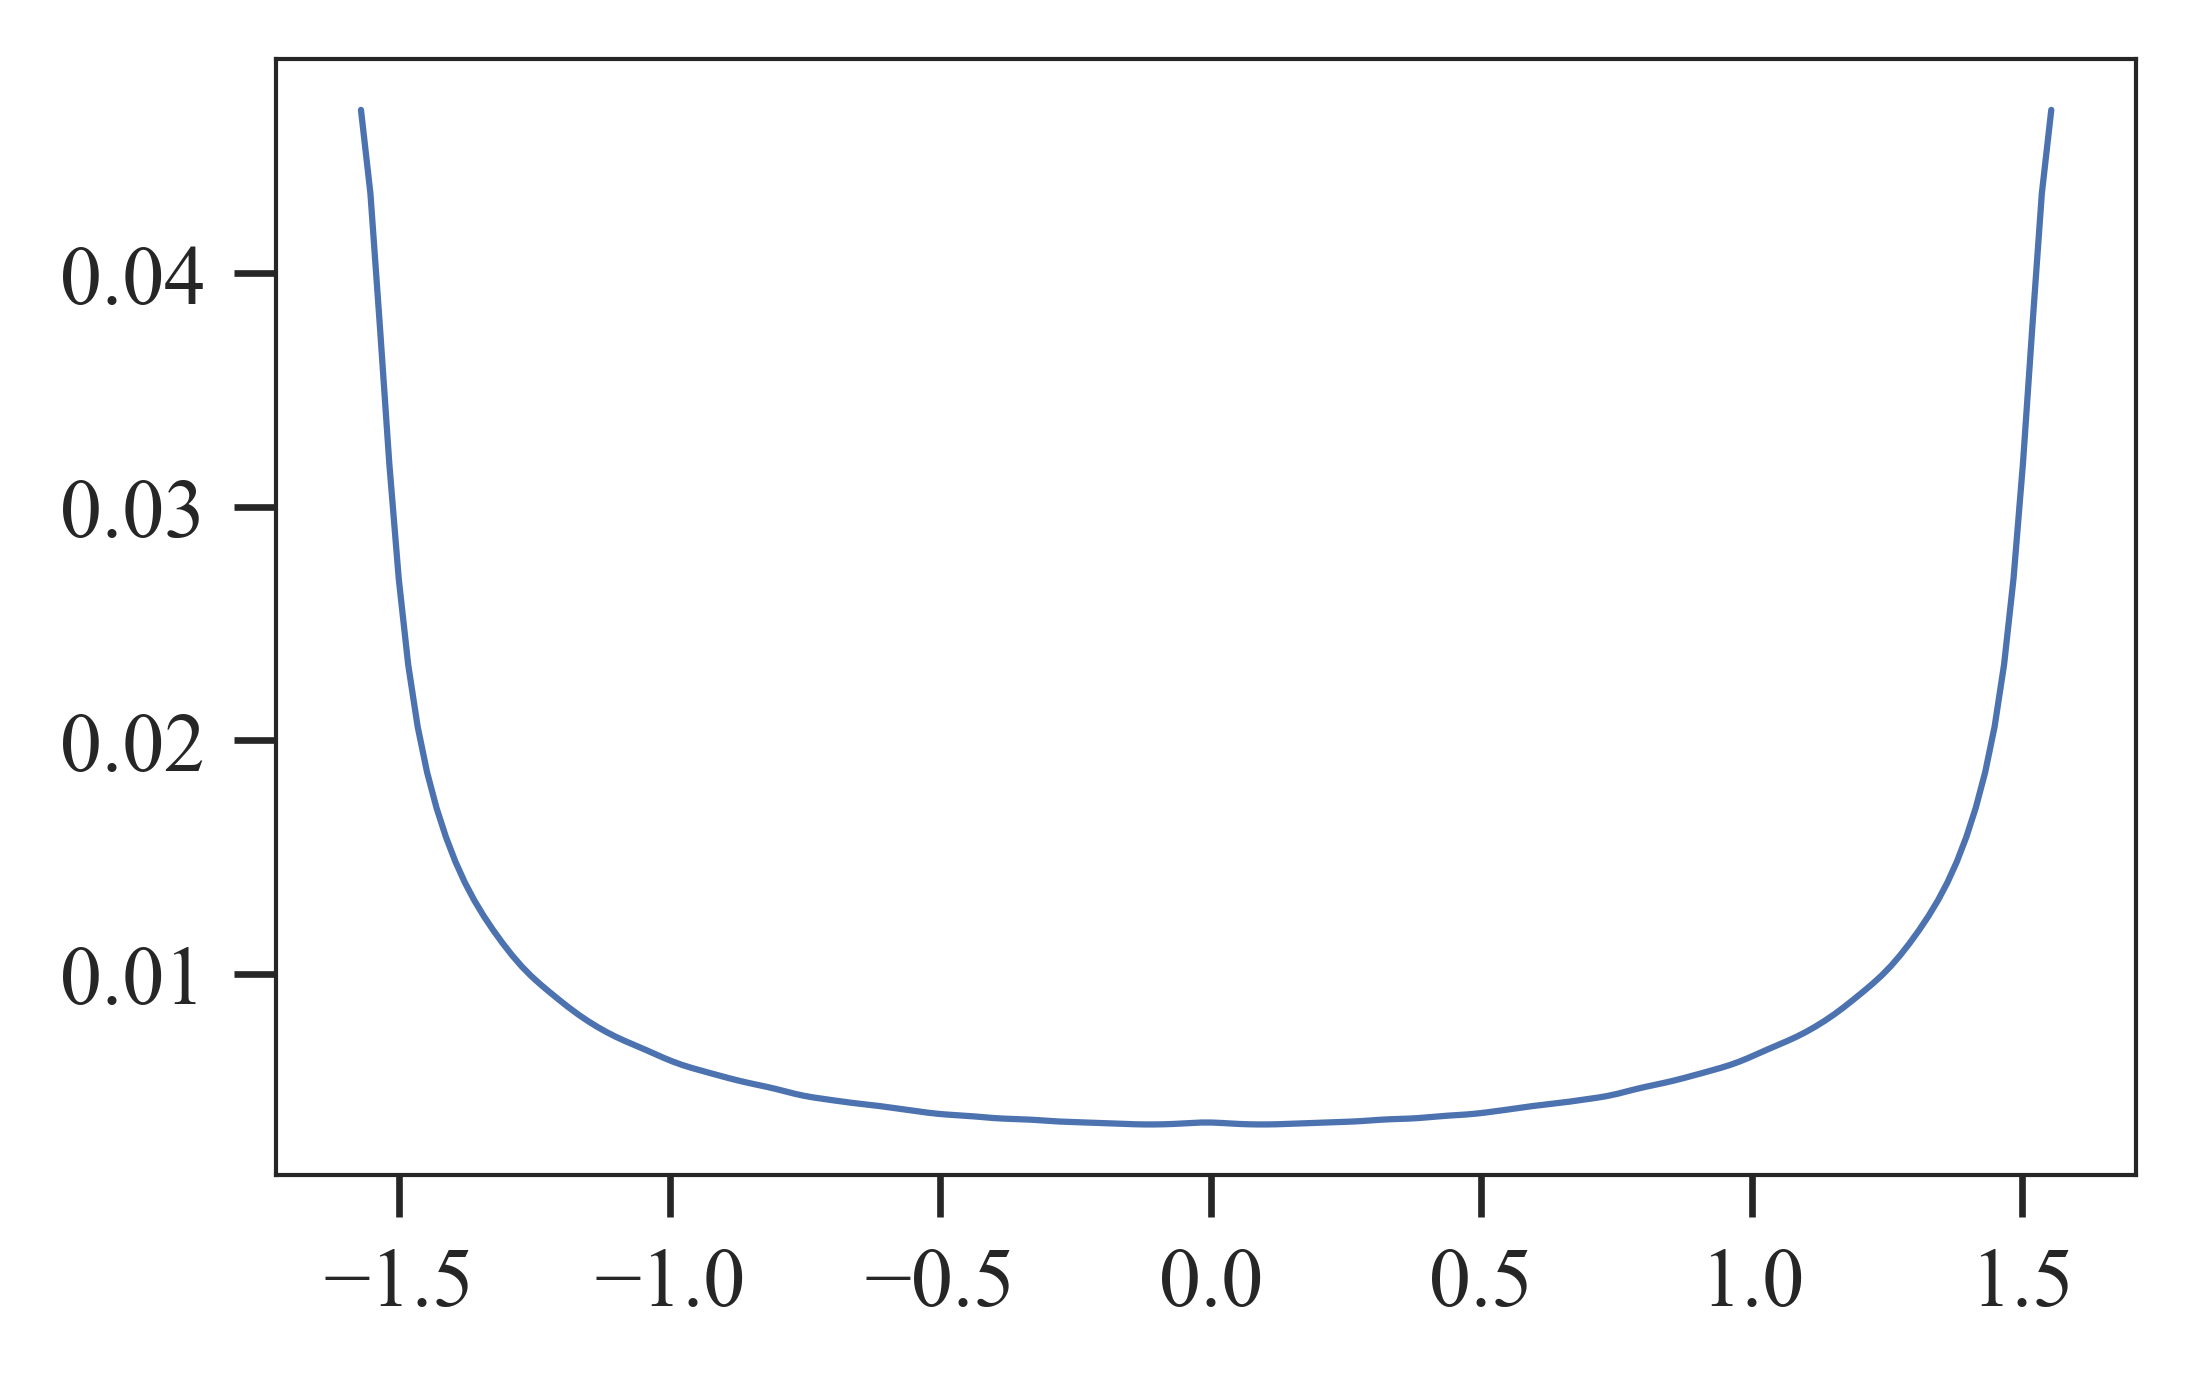

In [15]:
# Estimating p_theta2
alpha2 = phi
# alpha2 = np.deg2rad(alphaDeg)
theta_mat = np.array([np.arctan(np.tan(a) / np.cos(ph)) for a, ph in product(alpha2, phi)])
theta_mat = theta_mat.reshape((len(alpha), len(phi)))
print("min(theta): {0},\t max(theta): {1}".format(theta_mat.min(), theta_mat.max()))

p_phi2 = p_phi #* (phi**2)
print("Checking total proability: ", np.sum(p_phi2))
p_joint2 = np.array([p1 * p2 for p1, p2 in product(p_alpha, p_phi2)])
p_joint2 = p_joint2.reshape((len(p_alpha), len(p_phi2)))

theta2Deg = np.arange(-90, 90)
theta2 = np.deg2rad(theta2Deg)
dtheta2 = np.mean(theta2[1:] - theta2[:-1])
p_theta2 = []

# refer https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables
for th in theta2:
    p = 0
    for aidx, a in enumerate(alpha2):
        row = theta_mat[aidx, :]
        mask = (th < row) & (row <= th + dtheta2)
        p += np.sum(p_joint2[aidx, :] * mask) * np.abs(a)
    p_theta2.append(p)

p_theta2 = np.nan_to_num(p_theta2, nan=0) #/ np.sum(p_theta2)
print("Checking total proability: ", np.sum(p_theta2))
p_theta2 = gaussian_filter1d(p_theta2, 2)
print("Checking total proability: ", np.sum(p_theta2))

fig = plt.figure()
ax = fig.gca()
# ax.plot(phi, p_phi2, lw=0.75, label="$p'(\phi)$")
ax.plot(theta2, p_theta2, lw=0.75, label="$p'(\theta)$")